In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from scipy.integrate import odeint
from scipy.optimize import least_squares
from scipy import optimize
from datetime import date, timedelta
import random


Psi = pd.read_csv('Psi.csv')

npd = len(Psi)
Nfo = 8
Psi = Psi.values
Psif = [[0]]*npd

for k in range(1, npd):
    if (k-Nfo) < 0 :
        Psif[k] = 1/k*sum(Psi[0:k])
    else:
        Psif[k] = 1/Nfo*sum(Psi[k-Nfo:k])

Psif.pop(0)

def SIR(y,t, args):

    k = 1/4
    gamma_a = 1/3.5
    gamma_s = 1/4
    gamma_h = 0.18
    gamma_u = 0.13342706158133355
    mi_u = 0.4
    qsi = 0.53
    h = 0.06
    h_v = 0
    mi_h = 0.15
    ome_h = 0.14
    ome_u = 0.29
    delta = 0.31
    p = 0.2
    
    beta0, beta1, beta2, t1, t2 = args

    if t<t1:
        beta=beta0    
    elif (t>=t1) and (t < t2):
        beta=beta1
    elif (t>=t2):
        beta=beta2
    
    # beta_v = beta*0.5
    beta_v = 0
    

    delta_av = 0.31
    delta_sv = 0.31
    phi_e = 0.8
    k_v=1/3
    p_v = 0.1
    gamma_av = 1/3.5
    gamma_sv = 1/4
    gamma_vu=0.26
    qsi_v = 0.99
    eps=0.7
    mi_vh=0.03
    mi_vu=0.25
    gamma_vh=0.08
    tau=(6.6976e-05)*1.1
 
    # tau=novos_vacinados[int(t)]
    # N=14930634
    N=1
    psi= .5 #Psif[int(t)]

    S=y[0]
    E=y[1]
    Sv=y[2]
    Ev=y[3]
    Ia=y[4]
    Is=y[5]
    Iav=y[6]
    Isv=y[7]
    H=y[8]
    Hv=y[9]
    U=y[10]
    Uv=y[11]
    R=y[12]
    Rv=y[13]
    D=y[14]
    Nw=y[15]
    NwV=y[16]

    dSdt = -(1-psi)*beta*S*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)/N - tau/N
    dEdt = (1-psi)*beta*S*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)/N - k*E
    dSvdt = tau/N - (1-psi)*beta_v*Sv*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)/N - phi_e*eps*Sv
    dEvdt = (1-psi)*beta_v*Sv*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)/N - k_v*Ev
    dIadt = (1-p)*k*E - gamma_a*Ia
    dIsdt = p*k*E - gamma_s*Is
    dIavdt = (1-p_v)*k_v*Ev - gamma_av*Iav
    dIsvdt = p_v*k_v*Ev - gamma_sv*Isv
    dHdt = h*qsi*gamma_s*Is + (1-mi_u+ome_u*mi_u)*gamma_u*U - gamma_h*H
    dHvdt = h_v*qsi_v*gamma_sv*Isv + (1-mi_vu+ome_u*mi_vu)*gamma_vu*Uv - gamma_vu*Hv
    dUdt = h*(1-qsi)*gamma_s*Is + ome_h*gamma_h*H - gamma_u*U
    dUvdt = h_v*(1-qsi_v)*gamma_sv*Isv + ome_h*gamma_h*Hv - gamma_u*Uv
    dRdt = gamma_a*Ia + (1-h)*gamma_s*Is + (1-mi_h)*(1-ome_h)*gamma_h*H - phi_e*eps*Sv
    dRvdt = gamma_av*Iav + (1-h)*gamma_sv*Isv + (1-mi_vh)*(1-ome_h)*(gamma_vh*Hv)
    dDdt = (1-ome_h)*(mi_h*gamma_h*H +mi_vh*gamma_vh*Hv) + (1-ome_h)*(mi_u*gamma_u*U+mi_vu*gamma_vu*Uv)
    dNwdt = p*k*E + p_v*k_v*Ev
    dNwVdt = tau/N
    
    return [dSdt, dEdt, dSvdt, dEvdt, dIadt, dIsdt, dIavdt, dIsvdt, dHdt, dHvdt, dUdt, dUvdt, dRdt, dRvdt, dDdt, dNwdt, dNwVdt]



def lq_SIR(pars, data, ts0, q0):
    beta0, beta1, beta2, t1, t2 = pars

    #parameters
    parode = beta0, beta1, beta2, t1, t2

    #calls integrator

    qs = odeint(SIR, q0, ts0, args=(parode,),mxstep=1000000)
    mortos = np.diff(qs[:,-3])*14930634

    #define the standardized residuals
    errMortos = (mortos - data) / np.sqrt(mortos+1)

    return np.r_[errMortos] 

def Best_Fit(data,n_tries, ts0, q0):

    # #DEEFINE THE INTERVALS OF PARS
    intervals = np.array([[0, 4.], [0, 4.], [0, 4.], [0, 106], [106, 230]])

    #NUMBER OF FITS
    #best error starts at inft 
    best_err = np.inf
    #aj the number of best fists 
    aj = 0

    for i in range(n_tries):
        
        #create a set of parameters in the interval
        par0 = np.random.rand(len(intervals))
        par0 = intervals[:,0] + par0 * (intervals[:,1] - intervals[:,0])
        #try to fit

        try:
            res = least_squares(lambda pars: lq_SIR(pars,data, ts0, q0), par0, bounds=(intervals[:,0], \
                                                     intervals[:,1]))
            ier = res.status
            #if converges
            if ier >= 1 and ier <= 4:
                if res.cost < best_err:
                    #best_err = erro
                    best_err = res.cost
                    #best_pop = parametro
                    best_pop = res.x
                    #+1 best fit
                    aj = aj +1
                    print('achou',aj)

            #in does not converge, do nothing
        except:
            pass

    return best_pop

In [13]:
#Fitting the q-exp

#Define the state and the type of fit: (estado,capital,interior)
s='BA'
file='estado'

N=14873064

Dados = pd.read_csv ('dados/estado.csv')

df_all = Dados.query("date >= '2020-08-03'")

#Read the file
dates=df_all.date.values
data_casos=df_all.cases.values
data_mortes=df_all.deaths.values

#initial conditions
# Condições iniciais antigas
N0          = 14930634
R0          = 0.10283559664661251
H0          = 4.3098303683997274e-05
U0          = 3.6413963197633704e-05
V0          = 0.00013156000000000002
Rv0         = 5.250889303620339e-06
Is0         = 0.00046997515179609287
Ia0         = 2.7781087787366503e-17
Iav0        = 1.8028646508967777e-06 
Isv0        = 1.564127866469128e-16
E0          = 0.002225686099066243
Ev0         = 4.3573326897574477e-20
D0 = 0.0004120956935229304
# D0 = df.deaths.values[0]/N0
# S0 = ((N0-np.cumsum(df_all.cases.values)[-1])/N0) - Is0-Ia0-E0
# S0 = df.deaths.values[0]/N0
S0          = 0.8786027099495082
# D0 = 0
Nw0         = 0.022448675748757474
NwV0        = 0.006925288860900957
HV0 = 0
UV0 = 0

q0 = [S0,E0,V0,Ev0,Ia0,Is0,Iav0,Isv0,H0,HV0,U0,UV0,R0,Rv0,D0,Nw0,NwV0]

#Run the minimizer
n_tries=1000 #Quanto maior mais certeza do resultado. Colocar em 100 para roda com mais certeza (Ou até maiws se for necessário)
ts0=np.arange(len(data_mortes))

best_pop=Best_Fit(np.diff(data_mortes), n_tries, ts0, q0)

beta0, beta1, beta2, t1, t2 = best_pop

#Create an x axixis for plotting the function.

#parameters
parode = [beta0, beta1, beta2, t1, t2]
#calls integrator
qs = odeint(SIR,q0, ts0,args=(parode,),mxstep=1000000)


#Save Fig
#fig.savefig(r"Fits\\"+s+file+".png",bbox_inches='tight')



achou 1
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3725067705135D+03   r2 =  0.2658411410512D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3725067705135D+03   r2 =  0.2658411410512D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3725067705135D+03   r2 =  0.2658411410512D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3725067705135D+03   r2 =  0.2658411410512D-13
 lsoda--  warning..internal 

/var/folders/2m/0gvnp0t96w5c11k_w58tc6gh0000gn/T/ipykernel_15540/4216036158.py:94: RuntimeWarning: overflow encountered in double_scalars
  dSdt = -(1-psi)*beta*S*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)/N - tau/N
/var/folders/2m/0gvnp0t96w5c11k_w58tc6gh0000gn/T/ipykernel_15540/4216036158.py:95: RuntimeWarning: overflow encountered in double_scalars
  dEdt = (1-psi)*beta*S*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)/N - k*E
/var/folders/2m/0gvnp0t96w5c11k_w58tc6gh0000gn/T/ipykernel_15540/4216036158.py:95: RuntimeWarning: invalid value encountered in double_scalars
  dEdt = (1-psi)*beta*S*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)/N - k*E
/var/folders/2m/0gvnp0t96w5c11k_w58tc6gh0000gn/T/ipykernel_15540/4216036158.py:96: RuntimeWarning: invalid value encountered in double_scalars
  dSvdt = tau/N - (1-psi)*beta_v*Sv*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)/N - phi_e*eps*Sv
/var/folders/2m/0gvnp0t96w5c11k_w58tc6gh0000gn/T/ipykernel_15540/4216036158.py:97: RuntimeWarning: invalid value encountered i

 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.3730000000000D+03
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.3725067705134D+03   r2 =  0.3725067705135D+03
 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.3740000000000D+03
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.3725067705134D+03   r2 =  0.3725067705135D+03
 lsoda--  trouble from intdy. itask = i1, tout = r1  
      in above message,  i1 =         1
      in above message,  r1 =  0.3740000000000D+03
achou 2
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4648802957500D+03   r2 =  0.2398187790152D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  


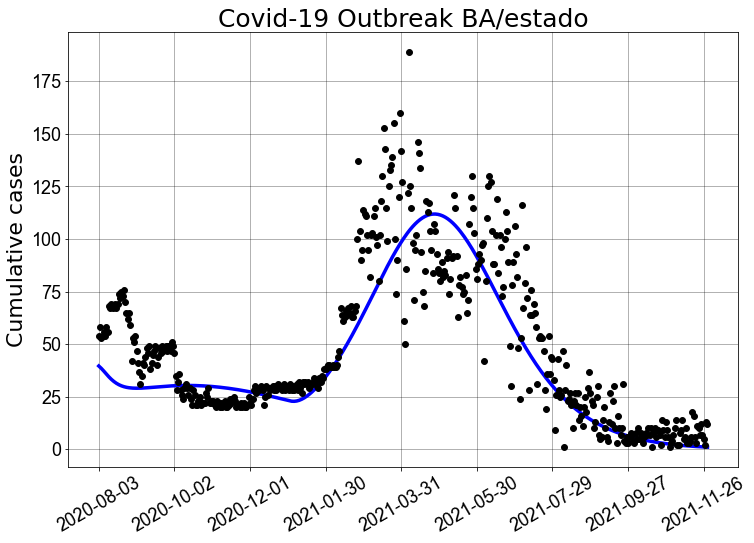

In [14]:
qi = qs[:,-3] #Casos acumulados

#Plotting
#Create the figure and the graph.
fig, ax = pl.subplots(figsize=(12,8))

#Create a grid for visualization.
ax.grid(which='major', axis='both', color='black',linewidth=1.,alpha=0.3)

#Plot the points(Scatters). s=size, zorder= priority->(puttin g the points in at the front of everything).

ax.scatter(dates[:len(dates)-1], np.diff(data_mortes), s=35,color='black',zorder=3,label='Reported data')
ax.autoscale()

#Plot the fitted function as a line.
ax.plot(dates[:len(dates)-1], np.diff((N0*qi)),color='blue', linewidth=3.5,label='Fitted function')

#Set the labels
ax.set_ylabel('Cumulative cases',fontsize=22)

#Set the title
ax.set_title('Covid-19 Outbreak '+s+'/'+file,fontsize=25)

#The size of the numbers on the axixis
ax.tick_params(labelsize=18)

#Limiting the ammount of dates on the X axixs
ax.xaxis.set_major_locator(pl.MaxNLocator(10))
#Rotating the dates for better visualization
pl.setp(ax.get_xticklabels(), rotation=30)


#Setting the font of the numbers on the axixis as ARIAL 
for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")  

#Show Graph       
pl.show()


# Controle antes 

In [15]:
# Condições iniciais antigas
D0          = 0;
N0          = 14930634;
R0          = 0;
H0          = 0;
U0          = 0;
V0          = 1000/N0;  
Rv0         = 0; 
Is0         = 2.015439771376298e-06;
Ia0         = 1.8028646508967777e-06;
Iav0        = 1.8028646508967777e-06; 
Isv0        = 1.8028646508967777e-06; 
E0          = 1.7639153732952095e-06;
Ev0         = 1.7639153732952095e-06;
S0          = (1-Is0-Ia0-E0);
Nw0         = 0;
NwV0        = 0;
HV0         = 0
UV0         = 0

condicoes_iniciais = [S0,E0,V0,Ev0,Ia0,Is0,Iav0,Isv0,H0,HV0,U0,UV0,R0,Rv0,D0,Nw0,NwV0];

In [16]:
def seiihurd(y, t):
    k = 1/4
    gamma_a = 1/3.5
    gamma_s = 1/4
    gamma_h = 0.18
    gamma_u = 0.13342706158133355
    mi_u = 0.4
    qsi = 0.53
    h = 0.06
    h_v = 0
    mi_h = 0.15
    ome_h = 0.14
    ome_u = 0.29
    delta = 0.31
    p = 0.2
    
    if t<20.178:
        beta=2.1317
    elif (t>=20.178-8) and (t < 72.94):
        beta=1.7645
    elif (t>=72.94) and (t < 148):
        beta=1.1281
    else:
        beta=1

    # beta_v = beta*0.5
    beta_v = 0
    
    if t<100: #inicio_da_vacinacao:
        delta_av = 0
        delta_sv = 0
        phi_e = 0
        k_v=0
        p_v = 0
        gamma_av = 0
        gamma_sv = 0
        gamma_vu=0
        qsi_v = 0 
        eps=0
        mi_vh=0
        mi_vu=0
        gamma_vh=0
        tau=0
    else:
        delta_av = 0.31
        delta_sv = 0.31
        phi_e = 0.8
        k_v=1/3
        p_v = 0.1
        gamma_av = 1/3.5
        gamma_sv = 1/4
        gamma_vu=0.26
        qsi_v = 0.99
        eps=0.7
        mi_vh=0.03
        mi_vu=0.25
        gamma_vh=0.08
        tau=(6.6976e-05)*1.1
 
    # tau=novos_vacinados[int(t)]
    # N=14930634
    N=1
    psi=Psif[int(t)]

    S=y[0]
    E=y[1]
    Sv=y[2]
    Ev=y[3]
    Ia=y[4]
    Is=y[5]
    Iav=y[6]
    Isv=y[7]
    H=y[8]
    Hv=y[9]
    U=y[10]
    Uv=y[11]
    R=y[12]
    Rv=y[13]
    D=y[14]
    Nw=y[15]
    NwV=y[16]

    dSdt = -(1-psi)*beta*S*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)/N - tau/N
    dEdt = (1-psi)*beta*S*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)/N - k*E
    dSvdt = tau/N - (1-psi)*beta_v*Sv*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)/N - phi_e*eps*Sv
    dEvdt = (1-psi)*beta_v*Sv*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)/N - k_v*Ev
    dIadt = (1-p)*k*E - gamma_a*Ia
    dIsdt = p*k*E - gamma_s*Is
    dIavdt = (1-p_v)*k_v*Ev - gamma_av*Iav
    dIsvdt = p_v*k_v*Ev - gamma_sv*Isv
    dHdt = h*qsi*gamma_s*Is + (1-mi_u+ome_u*mi_u)*gamma_u*U - gamma_h*H
    dHvdt = h_v*qsi_v*gamma_sv*Isv + (1-mi_vu+ome_u*mi_vu)*gamma_vu*Uv - gamma_vu*Hv
    dUdt = h*(1-qsi)*gamma_s*Is + ome_h*gamma_h*H - gamma_u*U
    dUvdt = h_v*(1-qsi_v)*gamma_sv*Isv + ome_h*gamma_h*Hv - gamma_u*Uv
    dRdt = gamma_a*Ia + (1-h)*gamma_s*Is + (1-mi_h)*(1-ome_h)*gamma_h*H - phi_e*eps*Sv
    dRvdt = gamma_av*Iav + (1-h)*gamma_sv*Isv + (1-mi_vh)*(1-ome_h)*(gamma_vh*Hv)
    dDdt = (1-ome_h)*(mi_h*gamma_h*H +mi_vh*gamma_vh*Hv) + (1-ome_h)*(mi_u*gamma_u*U+mi_vu*gamma_vu*Uv)
    dNwdt = p*k*E + p_v*k_v*Ev
    dNwVdt = tau/N
    
    return [dSdt, dEdt, dSvdt, dEvdt, dIadt, dIsdt, dIavdt, dIsvdt, dHdt, dHvdt, dUdt, dUvdt, dRdt, dRvdt, dDdt, dNwdt, dNwVdt]



In [17]:
tempo = list(range(0, len(Psif[:636])))
resultados = odeint(seiihurd, condicoes_iniciais, tempo)
resultados_modelo = resultados

Sm = N0*resultados[:,0]
Em = N0*resultados[:,1]
Svm = N0*resultados[:,2]
Evm = N0*resultados[:,3]
Iam = N0*resultados[:,4]
Ism = N0*resultados[:,5]
Iavm = N0*resultados[:,6]
Isvm = N0*resultados[:,7]
Hm = N0*resultados[:,8]
Hvm = N0*resultados[:,9]
Um = N0*resultados[:,10]
Uvm = N0*resultados[:,11]
Rm = N0*resultados[:,12]
Rvm = N0*resultados[:,13]
Dm = N0*resultados[:,14]
Nwm = N0*resultados[:,15]
NwVm = N0*resultados[:,16]



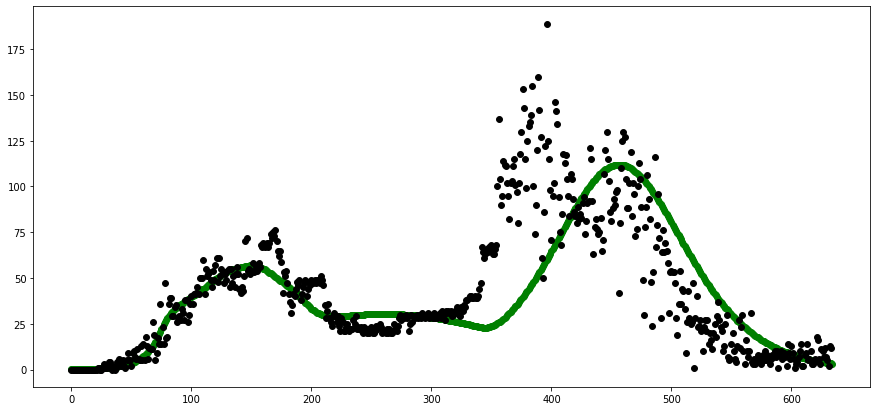

In [55]:
df_all = Dados
data_mortes2=df_all.deaths.values

ts1=np.arange(len(Psif[:636])-1)
fig, ax = pl.subplots(figsize=(15,7))

Nwm_d = np.diff(Dm)

first_up = np.diff(N0*Dm)[:190]
second_up = np.array(np.diff((N0*qi)))
deaths = np.append(first_up, second_up)

ax.scatter(ts1[:len(deaths)-1], deaths[:635], color='g',zorder=1, linewidth=1)
ax.scatter(ts1[:len(data_mortes2)-1], np.diff(data_mortes2), s=35,color='black',zorder=3,label='Reported data')
ax.autoscale()
pl.show()